# Feature Extraction

In [69]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import missingno as msno
from sklearn import preprocessing
import scipy
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tt2ma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [70]:
def process(df):
    # This is where you can do all your processing

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    return df


# Load the dataset
trainingSet = pd.read_csv("./data/train.csv") # (1697533, 10) all data

# Process the DataFrame
train_processed = process(trainingSet) # all data

# Load test set
submissionSet = pd.read_csv("./data/test.csv")

# Merge on Id so that the test set can have feature columns as well
testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
trainX =  train_processed[train_processed['Score'].notnull()]

In [ ]:
# Save data files
# testX.to_csv("./data/X_test.csv", index=False)
# trainX.to_csv("./data/X_train.csv", index=False)

# Explore Data Analysis

In [32]:
print(trainX.shape) # (1397533, 10) # after processing, remove all none row (testX)
print(submissionSet.shape) # (300000, 2) # Samples we need to predict
print(testX.shape) # (300000, 10)
trainX.head()


(1397533, 10)
(300000, 2)
(300000, 10)


,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness
0,0,0005019281,ADZPIG9QOCDG5,0,0,4.0,1203984000,good version of a classic,This is a charming version of the classic Dick...,0.0
1,1,0005019281,A35947ZP82G7JH,0,0,3.0,1388361600,Good but not as moving,It was good but not as emotionally moving as t...,0.0
2,2,0005019281,A3UORV8A9D5L2E,0,0,3.0,1388361600,Winkler's Performance was ok at best!,"Don't get me wrong, Winkler is a wonderful cha...",0.0
3,3,0005019281,A1VKW06X1O2X7V,0,0,5.0,1202860800,It's an enjoyable twist on the classic story,Henry Winkler is very good in this twist on th...,0.0
4,4,0005019281,A3R27T4HADWFFJ,0,0,4.0,1387670400,Best Scrooge yet,This is one of the best Scrooge movies out. H...,0.0


In [4]:
trainX.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Helpfulness
count,1.397533e+06,1.397533e+06,1.397533e+06,1.397533e+06,1.397533e+06,1.397533e+06
mean,8.490037e+05,3.574117e+00,5.305432e+00,4.111468e+00,1.262469e+09,3.995182e-01
std,4.901982e+05,1.777191e+01,2.078984e+01,1.196808e+00,1.289452e+08,4.193858e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,8.793792e+08,0.000000e+00
25%,4.246020e+05,0.000000e+00,0.000000e+00,4.000000e+00,1.164499e+09,0.000000e+00
50%,8.491910e+05,1.000000e+00,1.000000e+00,5.000000e+00,1.307750e+09,2.857143e-01
75%,1.273606e+06,3.000000e+00,5.000000e+00,5.000000e+00,1.373242e+09,8.571429e-01
max,1.697532e+06,6.084000e+03,6.510000e+03,5.000000e+00,1.406074e+09,8.000000e+00


According to the original code provided by the professor, we performed a very preliminary processing of the data set, separated the none value in it, and filled the empty value of helpfuness with 0, thus adding a 'Helpfulness' column

### Detect & Handle Missing Values

Text                      53
Summary                   19
Id                         0
ProductId                  0
UserId                     0
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Helpfulness                0
dtype: int64


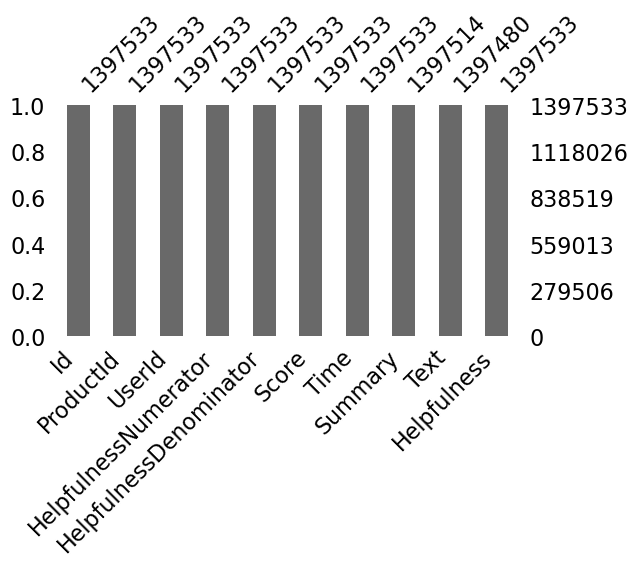

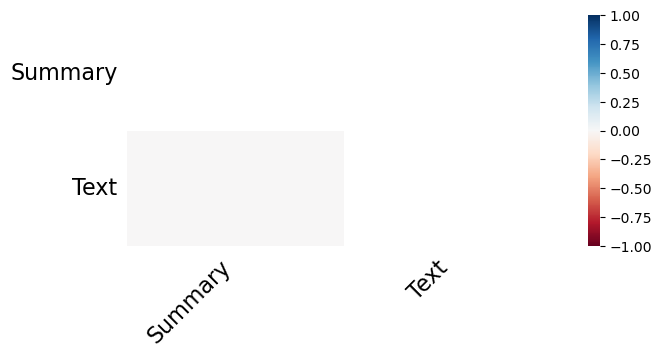

In [5]:
print(trainX.isnull().sum().sort_values(ascending=False)) 
  
# msno可以用于检测缺失值
msno.bar(trainX,figsize=(6,3)) # bar chart
#plt.show()
msno.heatmap(trainX,figsize=(7,3)) 
#heatmap
plt.show()

In [ ]:
trainX['Text'].loc[trainX['Text'].isna()] = ''
trainX['Summary'].loc[trainX['Summary'].isna()] = ''
testX['Text'].loc[testX['Text'].isna()] = ''
testX['Summary'].loc[testX['Summary'].isna()] = ''

# replace missing data in the whole dataset
train_processed['Text'].loc[train_processed['Text'].isna()] = ''
train_processed['Summary'].loc[train_processed['Summary'].isna()] = ''


After separating the unrated test data, we found that there were still missing values in trainX dataset. Both 'Summary' and 'Text' columns have some missing values. For the convenience of later processing, we will fill it blank.

### Product & User Feature

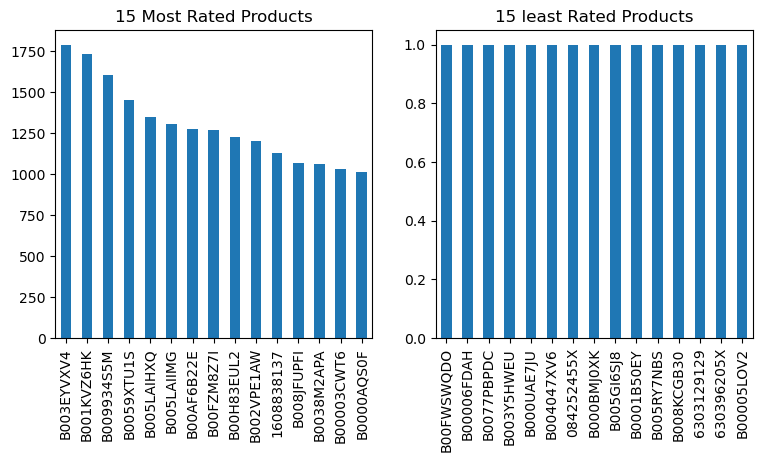

In [5]:
# Explore the Product

# most rated product
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
trainX['ProductId'].value_counts(sort=True).nlargest(15).plot.bar()
plt.title('15 Most Rated Products')
# plt.show()

# least rated product
plt.subplot(1,2,2)
trainX['ProductId'].value_counts(sort=True).nsmallest(15).plot.bar()
plt.title('15 least Rated Products')
plt.show()

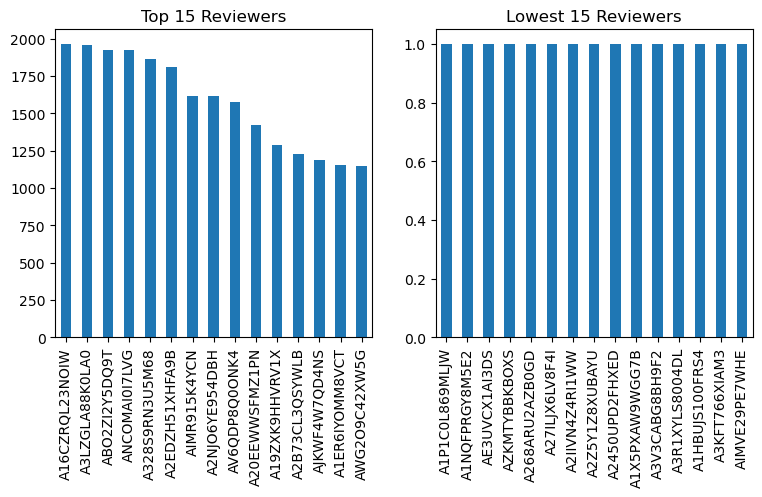

In [8]:
# User

# most rated product
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
trainX['UserId'].value_counts(sort=True).nlargest(15).plot.bar()
plt.title('Top 15 Reviewers')

# least rated product
plt.subplot(1,2,2)
trainX['UserId'].value_counts(sort=True).nsmallest(15).plot.bar()
plt.title('Lowest 15 Reviewers')
plt.show()

From the above statistical chart, we can see that there are no users who do not participate in the rating, and there are no products that have not been rated. But this data gap is a bit big. Both the largest data is greater than 1750, and the smallest is 1. We have a total of nearly 1.4 million pieces of data, however, the most users and products are not more than 2000. Therefore, we need to consider whether there will be some data that have a large deviation in the prediction of the model

### Helpfulness Numerator & Denominator Feature

0      641428
1      254236
2      134699
3       85976
4       56628
        ...  
388         1
465         1
296         1
952         1
554         1
Name: HelpfulnessNumerator, Length: 599, dtype: int64


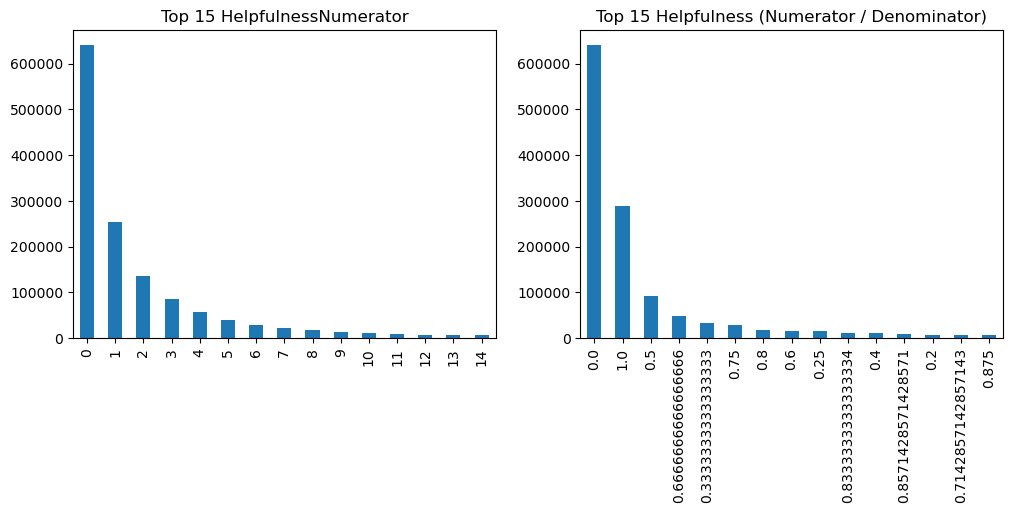

In [9]:
print(trainX['HelpfulnessNumerator'].value_counts())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
trainX['HelpfulnessNumerator'].value_counts(sort=True).nlargest(15).plot.bar()
plt.title('Top 15 HelpfulnessNumerator')
plt.subplot(1,2,2)
trainX['Helpfulness'].value_counts(sort=True).nlargest(15).plot.bar()
plt.title('Top 15 Helpfulness (Numerator / Denominator)')
plt.show()



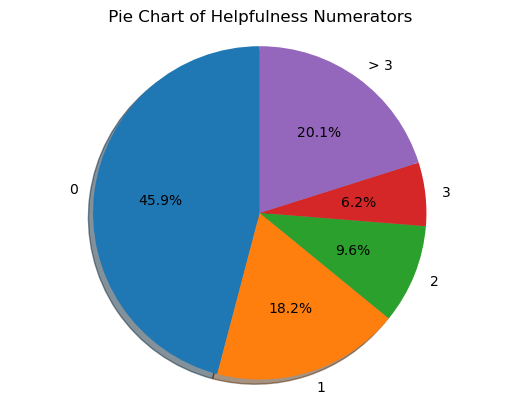

In [10]:
Numerator_0 = trainX[trainX['HelpfulnessNumerator'] == 0]['HelpfulnessNumerator'].value_counts()
Numerator_1 = trainX[trainX['HelpfulnessNumerator'] == 1]['HelpfulnessNumerator'].value_counts()
Numerator_2 = trainX[trainX['HelpfulnessNumerator'] == 2]['HelpfulnessNumerator'].value_counts()
Numerator_3 = trainX[trainX['HelpfulnessNumerator'] == 3]['HelpfulnessNumerator'].value_counts()
Numerator_4 = trainX[trainX['HelpfulnessNumerator'] > 3]['HelpfulnessNumerator'].value_counts()

labels = '0', '1', '2', '3', '> 3'
sizes = [Numerator_0.values.item(), Numerator_1.values.item(), Numerator_2.values.item(), Numerator_3.values.item(), Numerator_4.values.sum()]
explode = (0, 0, 0, 0, 0)
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal') 
plt.title(' Pie Chart of Helpfulness Numerators')
plt.show()


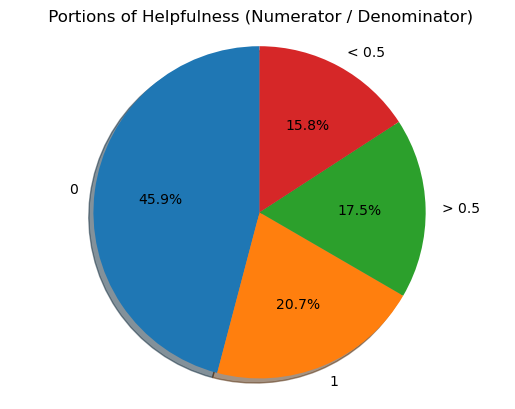

In [11]:
Numerator_0 = trainX[trainX['Helpfulness'] == 0]['Helpfulness'].value_counts()
Numerator_1 = trainX[trainX['Helpfulness'] == 1]['Helpfulness'].value_counts()
Numerator_GreaterThanHalf = trainX[(trainX['Helpfulness'] > 0.5) & (trainX['Helpfulness'] < 1)]['Helpfulness'].value_counts()
Numerator_LessThanHalf = trainX[(trainX['Helpfulness'] > 0) & (trainX['Helpfulness'] <= 0.5)]['Helpfulness'].value_counts()

# print(Numerator_GreaterThanHalf.sum())
labels = '0', '1', '> 0.5', '< 0.5'
sizes = [Numerator_0.values.item(), Numerator_1.values.item(), Numerator_GreaterThanHalf.sum(), Numerator_LessThanHalf.sum()]
# print(sizes) # [641428, 289770, 245022, 221307]
# print(sum(sizes)) # 1397527
explode = (0, 0, 0, 0)
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal') 
plt.title(' Portions of Helpfulness (Numerator / Denominator)')
plt.show()

Here we analyze the helpfulness feature by plotting bar and pie charts. We can find some interesting things. Nearly half of these data are 0, meaning no ratings are helpful or not helpful.   
Interestingly, the number of 'helpness' equal to 1 (everyone thought it was helpful) was very close to the number of the 'helpfulness numerator' equal to 1 (only one person thought it helpful), that is, the data with 'helpness' equal to 1 was basically only rated by one person, and found it helpful.  
At the same time, more than half (greater than 0.5) of the comments that 'helpful' accounted for 38% which is more than double the number of comments half say 'Not helpful' (15.8%). 

### Score Feature

5.0    746520
4.0    315587
3.0    165727
1.0     85615
2.0     84084
Name: Score, dtype: int64


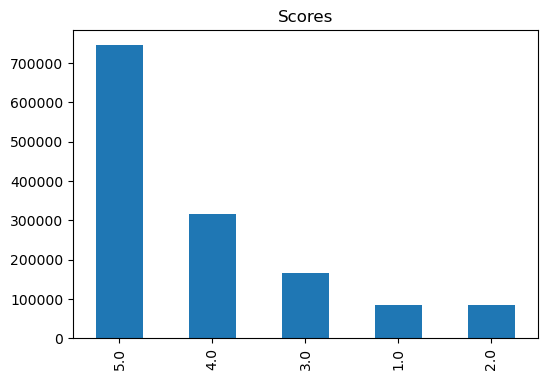

In [12]:
print(trainX['Score'].value_counts())
plt.figure(figsize=(6,4))
trainX['Score'].value_counts().plot.bar()
plt.title('Scores')
plt.show()

Reviewers are very friendly and tend to give a 5/5. The number that gives full marks is more than the rest combined. This affects our predictions and makes our model more inclined to give unseen data a 5/5. Such data distribution is very unbalanced, we need to do resampling.

### Group Some Above Features

       Helpfulness
Score             
1.0       0.362464
2.0       0.364157
3.0       0.370864
4.0       0.431812
5.0       0.400460


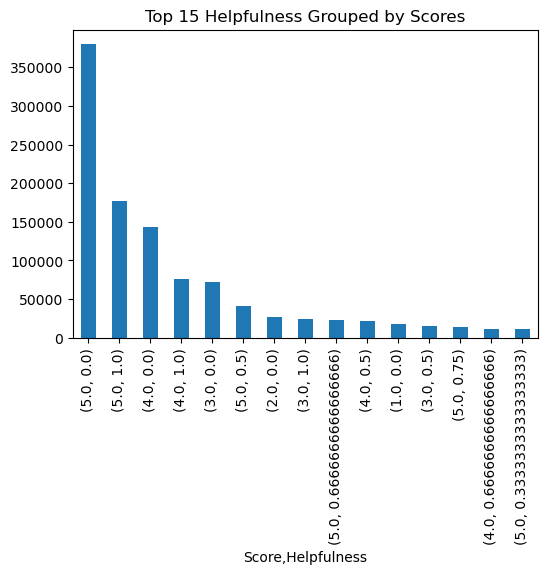

In [13]:
# analyze Helpfulness and Score, grouped by Score
plt.figure(figsize=(6,4))
print(trainX[['Helpfulness', 'Score']].groupby('Score').mean())
# list(trainX[['Helpfulness', 'Score']].groupby('Score'))
trainX[['Helpfulness', 'Score']].groupby('Score').value_counts(sort=True).nlargest(15).plot.bar()
plt.title('Top 15 Helpfulness Grouped by Scores')
plt.show()

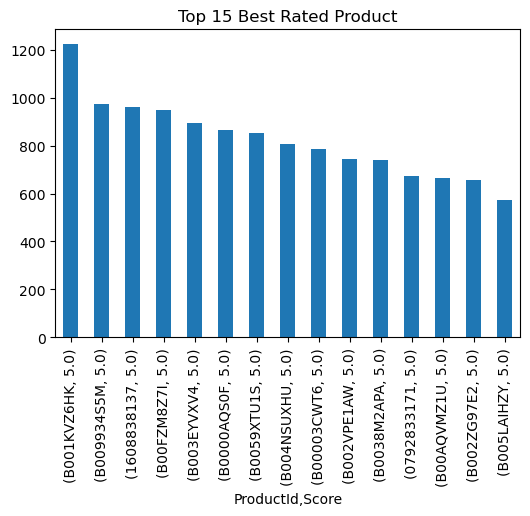

In [14]:
# print(trainX[['Score','ProductId']].groupby('ProductId').mean())
plt.figure(figsize=(6,4))
trainX[['Score','ProductId']].groupby('ProductId').value_counts(sort=True).nlargest(15).plot.bar()
plt.title('Top 15 Best Rated Product')
plt.show()

From the above chart, we can see that many movies rated 5 have no reviews. At the same time, the review of the movie with 5 points can basically be recognized by the majority of reviewers. However, for the chart below, I don't see much meaningful information.

### Summary	& Text

In [ ]:
trainX['TextLength'] = trainX.apply(lambda row: len(row['Text'].split(" ")) if type(row['Text']) == str else 0, axis = 1)
trainX['SummaryLength'] = trainX.apply(lambda row: len(row['Summary'].split(" ")) if type(row['Summary']) == str else 0, axis = 1)
# trainX

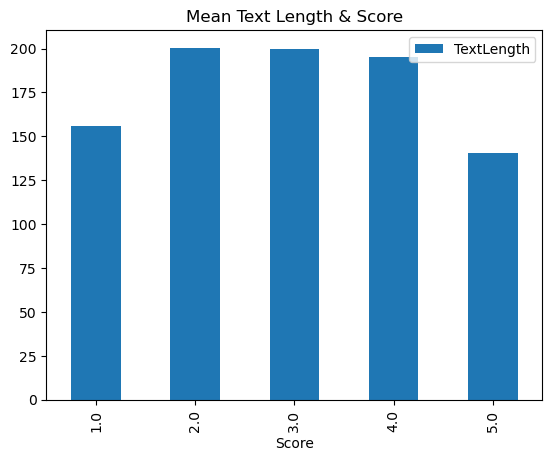

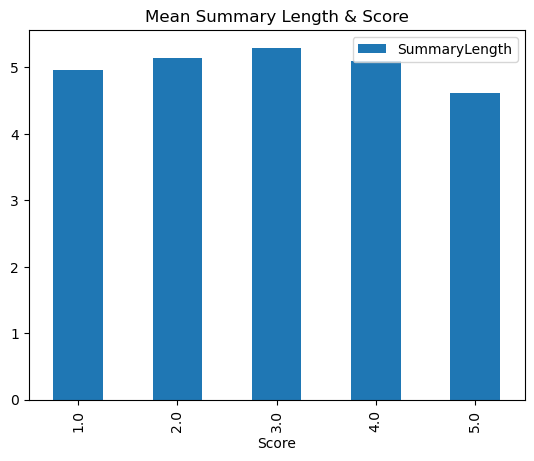

In [16]:
# try to find the relationship between Score and Text Length

# print(trainX[['TextLength', 'Score']].groupby('Score').mean())
trainX[['Score','TextLength']].groupby('Score').mean().plot.bar()
plt.title('Mean Text Length & Score')

trainX[['Score','SummaryLength']].groupby('Score').mean().plot.bar()
plt.title('Mean Summary Length & Score')
plt.show()


In the figures above, we tried to analyze the relationship between the length of the review and the rating. Overall, reviews rated 2-4 are longer. Perhaps the reviewer would like to elaborate more on the reasons for the general score, such as what the film's strengths and weaknesses are. The comments with the lowest and highest scores are often particularly appreciated or particularly disliked, and the comments of the commenters will be more distinct and certain, so the length of the comments is also shorter. It makes sense. But this cannot be a valid feature for building our model.

In [17]:
SummaryList = pd.Series(trainX['Summary']).to_list()
TextList = pd.Series(trainX['Text']).to_list()
print(SummaryList[0])
print(TextList[0])

good version of a classic
This is a charming version of the classic Dicken's tale.  Henry Winkler makes a good showing as the "Scrooge" character.  Even though you know what will happen this version has enough of a change to make it better that average.  If you love A Christmas Carol in any version, then you will love this.


In [18]:
# get the top 20 key words in Summary 
vectorizer = CountVectorizer(analyzer='word', stop_words='english', lowercase=True, max_features=20)
summaryTopWords = vectorizer.fit_transform(SummaryList)
print("Top 20 Summary key words: ")
print(vectorizer.get_feature_names_out())


Top 20 Summary key words: 
['bad' 'best' 'better' 'classic' 'dvd' 'excellent' 'film' 'fun' 'funny'
 'good' 'great' 'just' 'like' 'love' 'movie' 'season' 'series' 'stars'
 'story' 'time']


In [20]:
# get the top 20 key words in Text 
textTopWords = vectorizer.fit_transform(TextList)
print("Top 20 Text key words: ")
print(vectorizer.get_feature_names_out())

Top 20 Text key words: 
['best' 'don' 'dvd' 'film' 'good' 'great' 'just' 'like' 'love' 'make'
 'movie' 'movies' 'people' 'quot' 'really' 'series' 'story' 'time' 'watch'
 'way']


In [160]:
# stem summary words
stemmer = SnowballStemmer('english')
stem_articles = []
for sentence in trainX['Summary']:
    tokens = []
    for word in nltk.word_tokenize(sentence):
        tokens.append(word)
      # print(tokens)
    # Stem the tokens/words of a text/article
    stem_text = [stemmer.stem(token) for token in tokens]
  # Add to the stem_article
    stem_articles.append(stem_text)
  
print(stem_text) # the last text/article
print(len(stem_text))

['the', 'price', 'is', 'insan', '?', 'peopl', 'realli', 'need', 'to', 'wake', 'up', 'becaus', 'it', 'is', "n't", '!']
16


Here we extract the top 20 keywords of text and summary. We try to find the connection between these two. We can see that both have many words with positive sentiment. This is actually a bias, and as our analysis of the 'Score' above pointed out, this dataset is unbalanced, with scores of 5/5 far outpacing the rest.  
Except for these positive words, there is not much overlap between the two, because summary is more concise than text, so the vocabulary used will be different. So we can almost think that the two have a certain independence.

### Time Feature

In [ ]:
trainX['Date'] = pd.to_datetime(trainX['Time'], unit = 's')
trainX['Month'] = trainX['Date'].dt.month
trainX['Year'] = trainX['Date'].dt.year
# trainX['Hour'] = trainX['Date'].dt.hour
# trainX['Hour'].value_counts() # all zero
# print(trainX[['Month', 'Score']].groupby('Score').mean())

In [20]:
trainX.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness,TextLength,SummaryLength,Date,Month,Year
0,0,0005019281,ADZPIG9QOCDG5,0,0,4.0,1203984000,good version of a classic,This is a charming version of the classic Dick...,0.0,57,5,2008-02-26,2,2008
1,1,0005019281,A35947ZP82G7JH,0,0,3.0,1388361600,Good but not as moving,It was good but not as emotionally moving as t...,0.0,24,5,2013-12-30,12,2013
2,2,0005019281,A3UORV8A9D5L2E,0,0,3.0,1388361600,Winkler's Performance was ok at best!,"Don't get me wrong, Winkler is a wonderful cha...",0.0,49,6,2013-12-30,12,2013
3,3,0005019281,A1VKW06X1O2X7V,0,0,5.0,1202860800,It's an enjoyable twist on the classic story,Henry Winkler is very good in this twist on th...,0.0,30,8,2008-02-13,2,2008
4,4,0005019281,A3R27T4HADWFFJ,0,0,4.0,1387670400,Best Scrooge yet,This is one of the best Scrooge movies out. H...,0.0,28,3,2013-12-22,12,2013


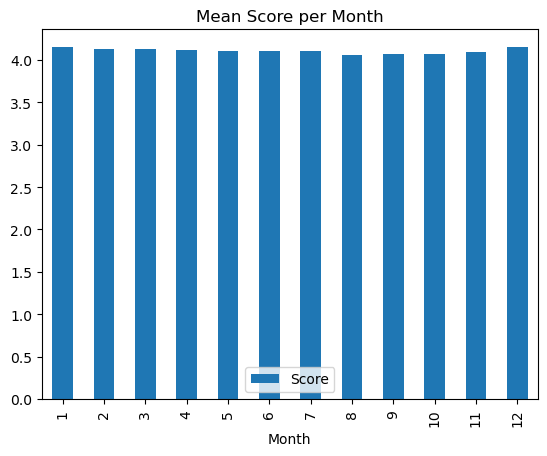

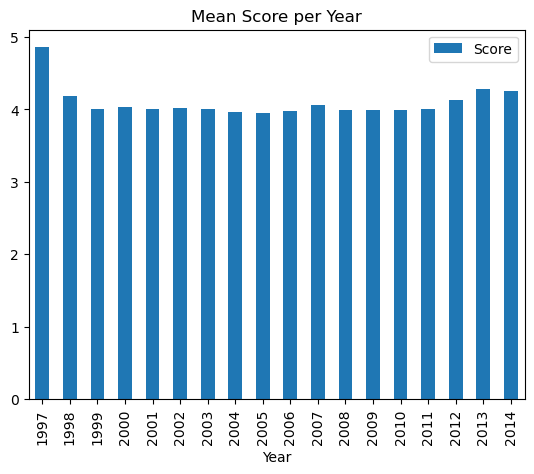

In [21]:
# try to figure out the relationship between score and time

trainX[['Score','Month']].groupby('Month').mean().plot.bar()
plt.title('Mean Score per Month')

trainX[['Score','Year']].groupby('Year').mean().plot.bar()
plt.title('Mean Score per Year')
plt.show()

We try to find the relationship between time and rating. Through analysis, I cannot find a significant connection between the two. The overall distribution is relatively uniform. Only 1997 you, reviewers are more inclined to give a 5.

# Data Preprocessing and Digitalize Features

### Tune the size of dataset

In [72]:
print(trainX.shape)
print(train_processed.shape)
print(trainX['Score'].value_counts())
print(trainX['Score'].value_counts().mean())

(1397533, 10)
(1697533, 10)
5.0    746520
4.0    315587
3.0    165727
1.0     85615
2.0     84084
Name: Score, dtype: int64
279506.6


In [55]:
fives = trainX.loc[trainX['Score'] == 5].sample(n=279506)
fours = trainX.loc[trainX['Score'] == 4].sample(n=279506)
# threes = train_processed.loc[train_processed['Score'] == 3].sample(n=279506)

small_train = pd.concat([trainX.loc[trainX['Score'] == 1], trainX.loc[trainX['Score'] == 2], trainX.loc[trainX['Score'] == 3], fives, fours])

In [56]:
print(small_train['Score'].value_counts().sum()) # 894438
print(small_train['Score'].value_counts())

894438
5.0    279506
4.0    279506
3.0    165727
1.0     85615
2.0     84084
Name: Score, dtype: int64


In [60]:
# get the balanced whole data set
# pandas.concat()通常用来连接DataFrame对象，默认纵向链接
small_data = pd.concat([small_train, testX])
small_data.shape


(1194438, 10)

In [61]:
train_processed = pd.concat([small_train, testX])

### Categorical Features (ProductID & UserID)

In [73]:
# whole data
train_processed.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness
0,0,0005019281,ADZPIG9QOCDG5,0,0,4.0,1203984000,good version of a classic,This is a charming version of the classic Dick...,0.0
1,1,0005019281,A35947ZP82G7JH,0,0,3.0,1388361600,Good but not as moving,It was good but not as emotionally moving as t...,0.0
2,2,0005019281,A3UORV8A9D5L2E,0,0,3.0,1388361600,Winkler's Performance was ok at best!,"Don't get me wrong, Winkler is a wonderful cha...",0.0
3,3,0005019281,A1VKW06X1O2X7V,0,0,5.0,1202860800,It's an enjoyable twist on the classic story,Henry Winkler is very good in this twist on th...,0.0
4,4,0005019281,A3R27T4HADWFFJ,0,0,4.0,1387670400,Best Scrooge yet,This is one of the best Scrooge movies out. H...,0.0


In [74]:
# Preprocessing ProductID and UserID
# one hot encoder 独热编码。将类别特征转化为二元特征
ENC = preprocessing.OneHotEncoder()
data_IDs = ENC.fit_transform(train_processed[['ProductId', 'UserId']])
data_IDs # 1697533x174012 sparse matrix

<1697533x174012 sparse matrix of type '<class 'numpy.float64'>'
	with 3395066 stored elements in Compressed Sparse Row format>

In [9]:
print(data_IDs.shape) # sparse matrix (1697533, 174012)


(1697533, 174012)


### Numerical Features

In [75]:
# normalize data
scaler = StandardScaler()
train_processed[['Helpfulness', 'Time']] = scaler.fit_transform(train_processed[['Helpfulness', 'Time']])
train_processed = train_processed.drop(['HelpfulnessDenominator','HelpfulnessNumerator'], axis=1)
train_processed.head()


,Id,ProductId,UserId,Score,Time,Summary,Text,Helpfulness
0,0,0005019281,ADZPIG9QOCDG5,4.0,-0.453260,good version of a classic,This is a charming version of the classic Dick...,-0.953032
1,1,0005019281,A35947ZP82G7JH,3.0,0.976825,Good but not as moving,It was good but not as emotionally moving as t...,-0.953032
2,2,0005019281,A3UORV8A9D5L2E,3.0,0.976825,Winkler's Performance was ok at best!,"Don't get me wrong, Winkler is a wonderful cha...",-0.953032
3,3,0005019281,A1VKW06X1O2X7V,5.0,-0.461972,It's an enjoyable twist on the classic story,Henry Winkler is very good in this twist on th...,-0.953032
4,4,0005019281,A3R27T4HADWFFJ,4.0,0.971464,Best Scrooge yet,This is one of the best Scrooge movies out. H...,-0.953032


In [76]:
# merge these two feature
# csr_matrix为按照row行来压缩稀疏矩阵的存储方式, csc_matrix 为按照colums列来压缩，计算方式与按行类似。
numerical_data = scipy.sparse.csr_matrix(train_processed[['Helpfulness', 'Time']].values)
numerical_data # 1697533x2

<1697533x2 sparse matrix of type '<class 'numpy.float64'>'
	with 3395066 stored elements in Compressed Sparse Row format>

### Text & Summary Features

In [77]:
# preprocessing for train part
text_vectorizer = TfidfVectorizer(input='content', analyzer='word', stop_words='english')
data_text_vectors = text_vectorizer.fit_transform(train_processed['Text'])

data_summary_vectorizer = TfidfVectorizer(input='content', analyzer='word', stop_words='english')
data_summary_vectors = data_summary_vectorizer.fit_transform(train_processed['Summary'])

In [78]:
print(data_summary_vectors.shape) # (1697533, 101440) （# of samples, # of words）
print(data_summary_vectors.nnz / float(data_summary_vectors.shape[0])) # it is sparse

(1697533, 101440)
2.879423846252179


### Create all useful features

In [32]:
# remove features we don't need anymore
train = trainX.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'TextLength','SummaryLength','Date','Month','Year'])
test = testX.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
train

,Score,ScaledHelpfulness,ScaledTime
0,4.0,-0.952627,-0.453565
1,3.0,-0.952627,0.976327
2,3.0,-0.952627,0.976327
3,5.0,-0.952627,-0.462276
4,4.0,-0.952627,0.970966
...,...,...,...
1697526,4.0,-0.555221,1.111007
1697529,5.0,0.636999,1.110337
1697530,5.0,-0.237295,1.111007
1697531,5.0,-0.952627,1.113017


In [33]:
test

,Score,ScaledHelpfulness,ScaledTime
0,NaN,-0.954921,0.942940
1,NaN,-0.954921,0.997926
2,NaN,-0.954921,0.989209
3,NaN,0.748280,-1.003050
4,NaN,-0.954921,0.952327
...,...,...,...
299995,NaN,-0.954921,1.103205
299996,NaN,-0.277512,1.112593
299997,NaN,-0.239577,1.113934
299998,NaN,0.748280,1.115946


* Different Feature Combinations

In [14]:
# Attmep 1: RMSE: 1.57
# combine all features without text data
# hstack将矩阵按照列height进行拼接, vstack 将矩阵按照行进行拼接，对应的列数必须相等
allFeature1 = hstack([numerical_data, data_IDs]) # 1697533x174014 sparse matrix 
allFeature1

<1697533x174014 sparse matrix of type '<class 'numpy.float64'>'
	with 6790132 stored elements in Compressed Sparse Row format>

In [52]:
## Attemp 2: RMSE: 1.25
# combine all features without data_text_vectors
allFeature2 = hstack([data_summary_vectors, numerical_data, data_IDs]) # 1697533x275454 sparse matrix 
allFeature2

<1697533x275454 sparse matrix of type '<class 'numpy.float64'>'
	with 11678049 stored elements in Compressed Sparse Row format>

In [79]:
## Attemp 3: RMSE: 0.96
# combine all features 
allFeature3 = hstack([ data_text_vectors, data_summary_vectors, numerical_data, data_IDs]) # 1397533x991400 sparse matrix 
allFeature3 # 1697533x1090801

<1697533x1090801 sparse matrix of type '<class 'numpy.float64'>'
	with 117730404 stored elements in Compressed Sparse Row format>

In [28]:
## Attemp 4:
# only combine data_summary_vectors, numerical_data features 
allFeature4 = hstack([data_summary_vectors, numerical_data]) # 1397533x991400 sparse matrix 
allFeature4 # 1697533x101442

<1697533x101442 sparse matrix of type '<class 'numpy.float64'>'
	with 8282983 stored elements in Compressed Sparse Row format>

### Split the Dataset

In [81]:
# split the test data from the whole dataset
mask = train_processed["Score"].isnull()
test_index = mask.to_numpy().nonzero()[0]
train_index = (~ mask).to_numpy().nonzero()[0]
train_X = scipy.sparse.csr_matrix(allFeature3)[train_index] 
test_X = scipy.sparse.csr_matrix(allFeature3)[test_index] 
train_X # 1397533x275454 

<1397533x1090801 sparse matrix of type '<class 'numpy.float64'>'
	with 96917078 stored elements in Compressed Sparse Row format>

In [83]:
test_X

<300000x1090801 sparse matrix of type '<class 'numpy.float64'>'
	with 20813326 stored elements in Compressed Sparse Row format>

In [84]:
# split the labels for test data for kaggle and training data
train_Y = train_processed['Score'].loc[train_processed['Score'].isna() == False]
test_Y = train_processed['Score'].loc[train_processed['Score'].isna()] # test for kaggle

# Score Lables for train and test
train_Y = train_Y.reset_index()['Score']
test_Y = test_Y.reset_index()['Score']
train_Y

0          4.0
1          3.0
2          3.0
3          5.0
4          4.0
          ... 
1397528    4.0
1397529    5.0
1397530    5.0
1397531    5.0
1397532    5.0
Name: Score, Length: 1397533, dtype: float64

In [85]:
test_Y

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
299995   NaN
299996   NaN
299997   NaN
299998   NaN
299999   NaN
Name: Score, Length: 300000, dtype: float64

### Rebalance Data Class

In [86]:
print(trainX['Score'].value_counts())

5.0    746520
4.0    315587
3.0    165727
1.0     85615
2.0     84084
Name: Score, dtype: int64


In [33]:
# From above analysis, we know there are too many 5/5 score
# Method 1: under sample
rus = RandomUnderSampler(random_state=42)
train_X, train_Y = rus.fit_resample(train_X, train_Y)
print('Resampled dataset shape %s' % Counter(train_Y))

Resampled dataset shape Counter({1.0: 84084, 2.0: 84084, 3.0: 84084, 4.0: 84084, 5.0: 84084})


In [73]:
# Method 2: over sample
ros = RandomOverSampler(random_state=42)
train_X, train_Y = ros.fit_resample(train_X, train_Y)
print('Resampled dataset shape %s' % Counter(train_Y))

Resampled dataset shape Counter({1.0: 279506, 2.0: 279506, 3.0: 279506, 5.0: 279506, 4.0: 279506})


### Reduce Data Dimensionality

In [38]:
# train_X # 420420x101442 sparse matrix
test_X # 300000x101442 sparse matrix

<300000x101442 sparse matrix of type '<class 'numpy.float64'>'
	with 1463789 stored elements in Compressed Sparse Row format>

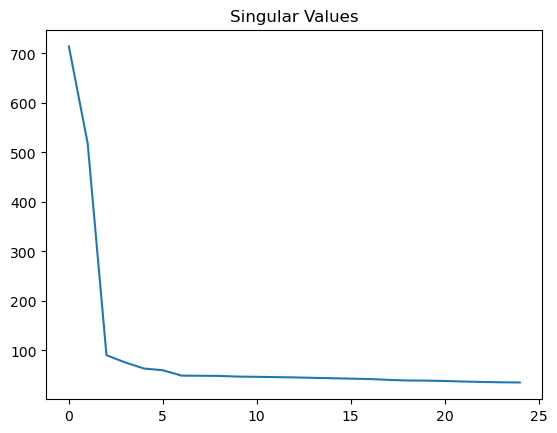

In [39]:
# TruncatedSVD k可以非常好的处理稀疏矩阵。

dim_reduced_dataset = TruncatedSVD(25).fit_transform(train_X)
dim_reduced_dataset.shape

# svd decomposition
u, s, vt = np.linalg.svd(dim_reduced_dataset, full_matrices=False)

# plot
plt.plot(s)
plt.title('Singular Values')
plt.show()

In [41]:
# Thus rank = 4 is enough
train_X = TruncatedSVD(4).fit_transform(train_X)
test_X = TruncatedSVD(4).fit_transform(train_X)


In [42]:
train_X.shape

(420420, 4)

# Build Model & Predict

### KNN

In [67]:
# Load files into DataFrames
# X_train = pd.read_csv("./data/X_train.csv")
# X_submission = pd.read_csv("./data/X_test.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        train_X, 
        train_Y, 
        test_size=1/4, 
        random_state=42
    )

# Learn the model
model = KNeighborsClassifier(n_neighbors=20).fit(X_train, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test)


Accuracy on testing set =  0.3176157176157176
root mean-squared error =  1.6087920276442782


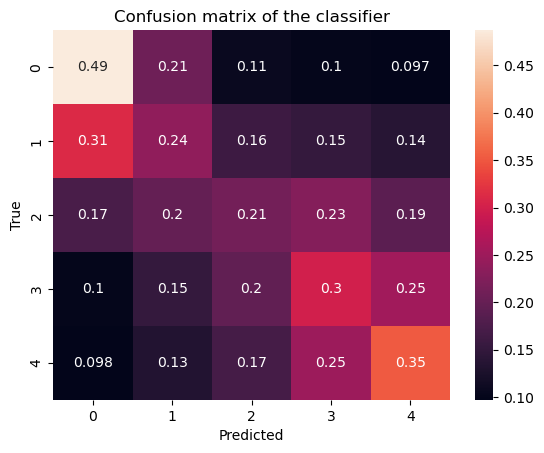

In [68]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
MSE = mean_squared_error(Y_test, Y_test_predictions) 
RMSE = np.sqrt(MSE) 
print("root mean-squared error = ", RMSE)

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Lasso Regression

In [62]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        train_X, 
        train_Y, 
        test_size=1/4, 
        random_state=42
    )

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)
# Fit model
model.fit(X_train, Y_train)

# Show best value of penalization chosen by cross validation
LassoCV(cv=5, max_iter=10000, random_state=0)
print("Best alpha:", model.alpha_)

# Set best alpha and use the best model 
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, Y_train)

# Predict the score using the model
Y_test_predictions = lasso_best.predict(X_test)

Best alpha: 0.00012145807025031787


In [64]:
print(Y_test_predictions)
Y_test_predictions = np.rint(Y_test_predictions)
print(Y_test_predictions)
Y_test_predictions = Y_test_predictions.reshape(-1, 1)
Y_test_predictions.shape
print(Y_test_predictions)

[2.81359991 2.77381077 3.19707743 ... 2.83505289 3.23187759 3.18289439]
[3. 3. 3. ... 3. 3. 3.]
[[3.]
 [3.]
 [3.]
 ...
 [3.]
 [3.]
 [3.]]


Accuracy on testing set =  0.20705960705960705
root mean-squared error =  1.4043772084820785


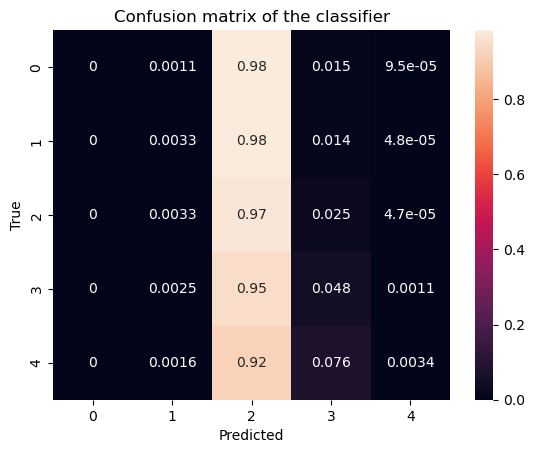

In [65]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

MSE = mean_squared_error(Y_test, Y_test_predictions) 
RMSE = np.sqrt(MSE) #
print("root mean-squared error = ", RMSE)

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


(50000.0, 250000.0)

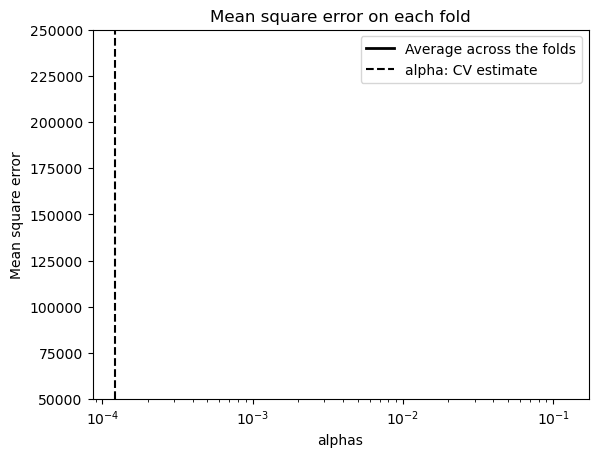

In [66]:
# plot results of cross-validation with mean squared erros
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 50000, 250000
plt.ylim(ymin, ymax)

### Random Forest

the prediction of random forest will be float.

In [43]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        train_X, 
        train_Y, 
        test_size=1/4, 
        random_state=42
    )

# Random Forest
model = RandomForestRegressor(n_estimators=20, random_state=0).fit(X_train, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test)

In [58]:
print(Y_test_predictions)
Y_test_predictions = np.rint(Y_test_predictions) # convert to int 
print(Y_test_predictions)
Y_test_predictions = Y_test_predictions.reshape(-1, 1)
Y_test_predictions.shape
print(Y_test_predictions)

[4. 3. 4. ... 4. 1. 4.]
[4. 3. 4. ... 4. 1. 4.]
[[4.]
 [3.]
 [4.]
 ...
 [4.]
 [1.]
 [4.]]


Accuracy on testing set =  0.284572570286856
root mean-squared error =  1.326338629149494


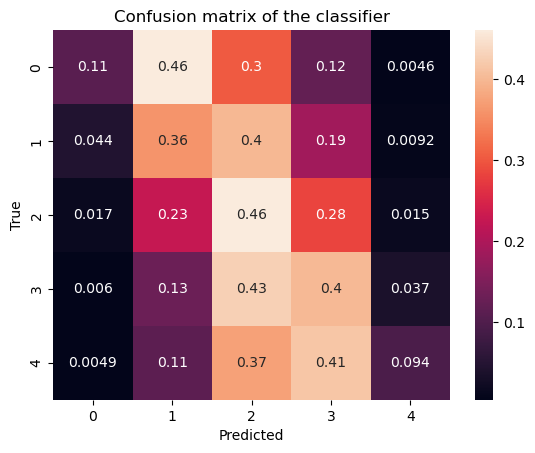

In [60]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

MSE = mean_squared_error(Y_test, Y_test_predictions) 
RMSE = np.sqrt(MSE) #
print("root mean-squared error = ", RMSE)

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Decision Tree

In [89]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        train_X, 
        train_Y, 
        test_size=1/4, 
        random_state=42
    )

# From above, we set max_depth = 3
model = DTC().fit(X_train, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test)

Accuracy on testing set =  0.3393463679177965
root mean-squared error =  1.5839809866720695


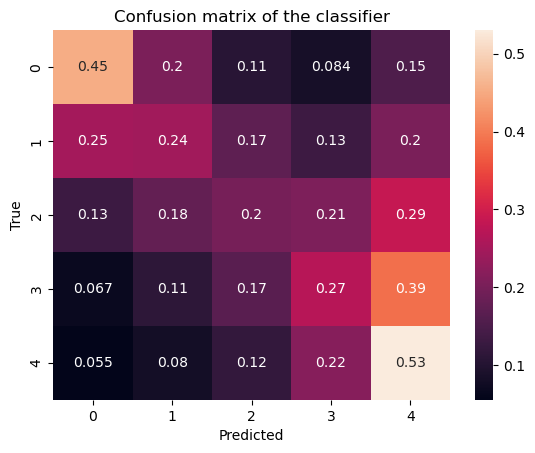

In [90]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

MSE = mean_squared_error(Y_test, Y_test_predictions) 
RMSE = np.sqrt(MSE) #
print("root mean-squared error = ", RMSE)

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Load submission set
X_submission = pd.read_csv("./data/test.csv")
submission = pd.DataFrame(X_submission)
submission['Score'] = model.predict(test_X)

# Create the submission file
submission.to_csv("./data/submission.csv", index=False)

### Logistic Regression

We got the best result by logistic regression. In this attempt, I used all features, allFeature3. At the same time, do not balance the data, and no need for data dimensionality reduction.

In [ ]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        train_X, 
        train_Y, 
        test_size=1/4, 
        random_state=42
    )

# Logistics Regression
model = LogisticRegression(random_state = 0).fit(X_train, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test)


Accuracy on testing set =  0.6685051404758089
root mean-squared error =  0.8755785824537409


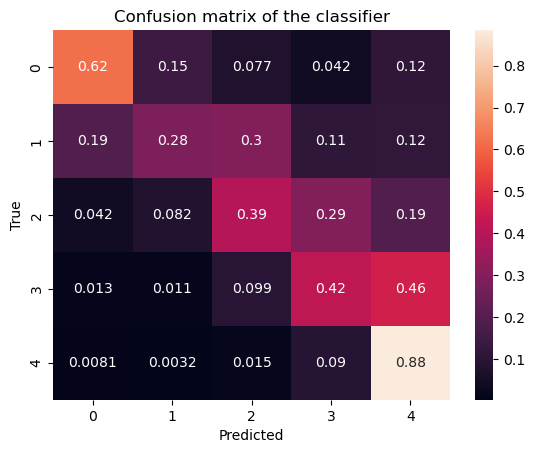

In [88]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Print the root mean-squared error (RMSE)
MSE = mean_squared_error(Y_test, Y_test_predictions) 
RMSE = np.sqrt(MSE) 
print("root mean-squared error = ", RMSE) # 0.91


# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Load submission set
X_submission = pd.read_csv("./data/test.csv")
submission = pd.DataFrame(X_submission)
submission['Score'] = model.predict(test_X)

# Create the submission file
submission.to_csv("./data/submission.csv", index=False)